In [143]:
#Importamos las librerias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage import feature
import cv2
import os
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from PIL import Image
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
sns.set_style('darkgrid')

In [23]:
#Importamos el dataset
df = pd.read_csv('data_imagenes.csv')

In [3]:
#Cargamos una imagen
img = cv2.imread('imagenes/an2i_left_angry_sunglasses.pgm', cv2.IMREAD_GRAYSCALE)

In [4]:
#Observamos las dimensiones de la imagen
img.shape

(120, 128)

<center>

# 1. Preprocesamiento de las imagenes
</center>

## 1.1 Aumento de resolución de imagen

In [5]:
#Aumentamos la resolucion de las imagenes con 3 metodos diferentes
high_res_img_linear = cv2.resize(img, (500, 500), interpolation=cv2.INTER_LINEAR)
high_res_img_cubic = cv2.resize(img, (500, 500), interpolation=cv2.INTER_CUBIC)
high_res_img_lanc = cv2.resize(img, (500, 500), interpolation=cv2.INTER_LANCZOS4)

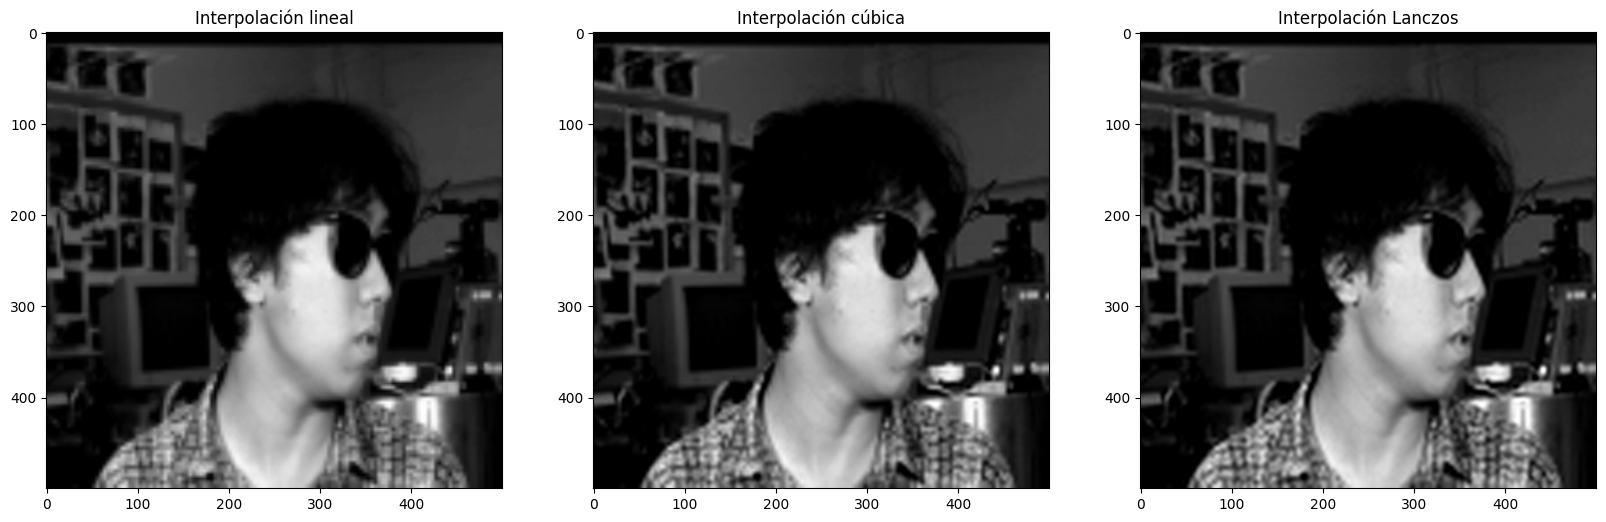

In [6]:
#Se grafican los resultados y elegimos el mejor metodo
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
ax[0].imshow(high_res_img_linear, cmap='gray')
ax[0].set_title('Interpolación lineal')
ax[1].imshow(high_res_img_cubic, cmap='gray')
ax[1].set_title('Interpolación cúbica')
ax[2].imshow(high_res_img_lanc, cmap='gray')
ax[2].set_title('Interpolación Lanczos')
plt.show()


### Al observar los resultados vemos que la interpolacion cubica y de Lanczos no difieren mucho en calidad, mientras que en la interpolacion lineal se ve la menor calidad 

## 1.2 Filtro de alta frecuencia para resaltar detalles finos (bordes)

In [7]:
#Se establece un kernel con valor central mayor que el resto para resaltar los bordes
kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
sharpened_img_linear = cv2.filter2D(high_res_img_linear, -1, kernel)
sharpened_img_cubic = cv2.filter2D(high_res_img_cubic, -1, kernel)
sharpened_img_lanc = cv2.filter2D(high_res_img_lanc, -1, kernel)

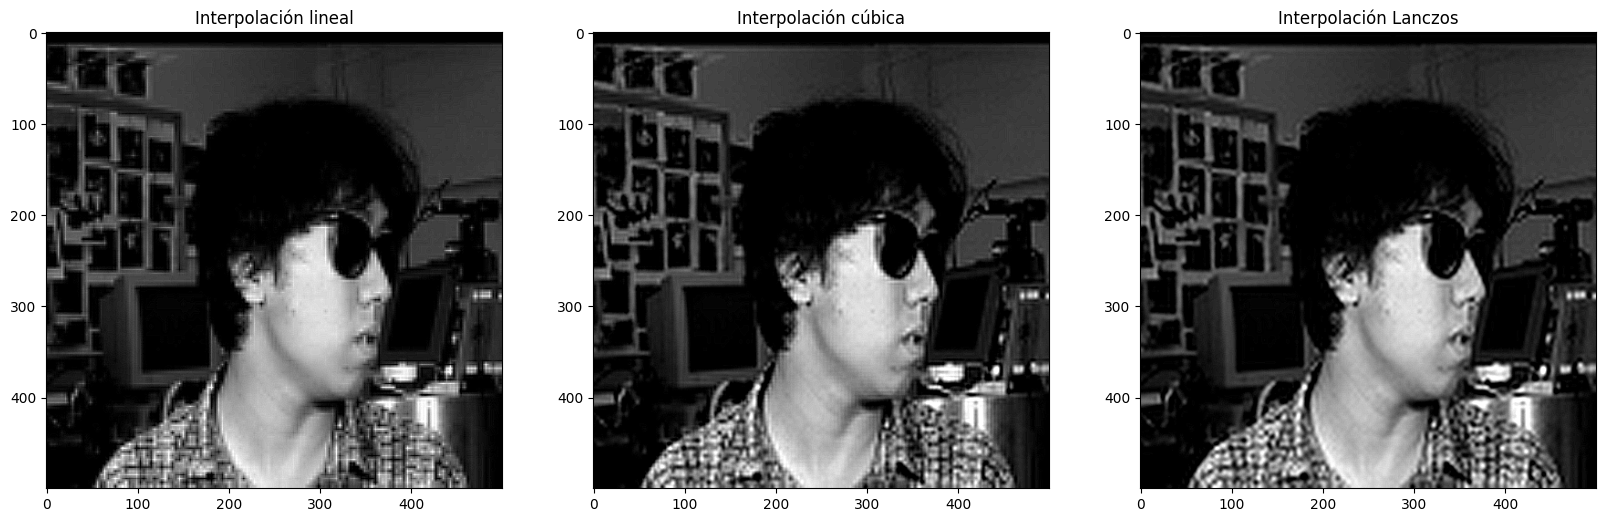

In [8]:
#Se grafican los resultados y elegimos el mejor metodo
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
ax[0].imshow(sharpened_img_linear, cmap='gray')
ax[0].set_title('Interpolación lineal')
ax[1].imshow(sharpened_img_cubic, cmap='gray')
ax[1].set_title('Interpolación cúbica')
ax[2].imshow(sharpened_img_lanc, cmap='gray')
ax[2].set_title('Interpolación Lanczos')
plt.show()

### Elegimos la interpolazion cubica sobre las demas debido a su buen desempeño y bajo coste computacional

## 1.3 Umbralizacion y operacion prixel a pixel

In [11]:
#Se crea una matriz de 50s para sumar y restar a la imagen 
matriz = np.ones(sharpened_img_cubic.shape, dtype=np.uint8)*230
img_brillante = cv2.add(sharpened_img_cubic, matriz)
img_oscura = cv2.subtract(sharpened_img_cubic, matriz)

In [17]:
#Se aplica un treshold binario a las imagenes
img_brillante_treshold = cv2.threshold(img_brillante, 230, 255, cv2.THRESH_BINARY)[1]
img_oscura_treshold = cv2.threshold(img_oscura, 80, 255, cv2.THRESH_BINARY)[1]

In [38]:
#Se aplica un treshold adaptativo a las imagenes
img_brillante_treshold_adaptative = cv2.adaptiveThreshold(img_brillante, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 31, 2)
img_oscura_treshold_adaptative = cv2.adaptiveThreshold(img_oscura, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 7, 5)

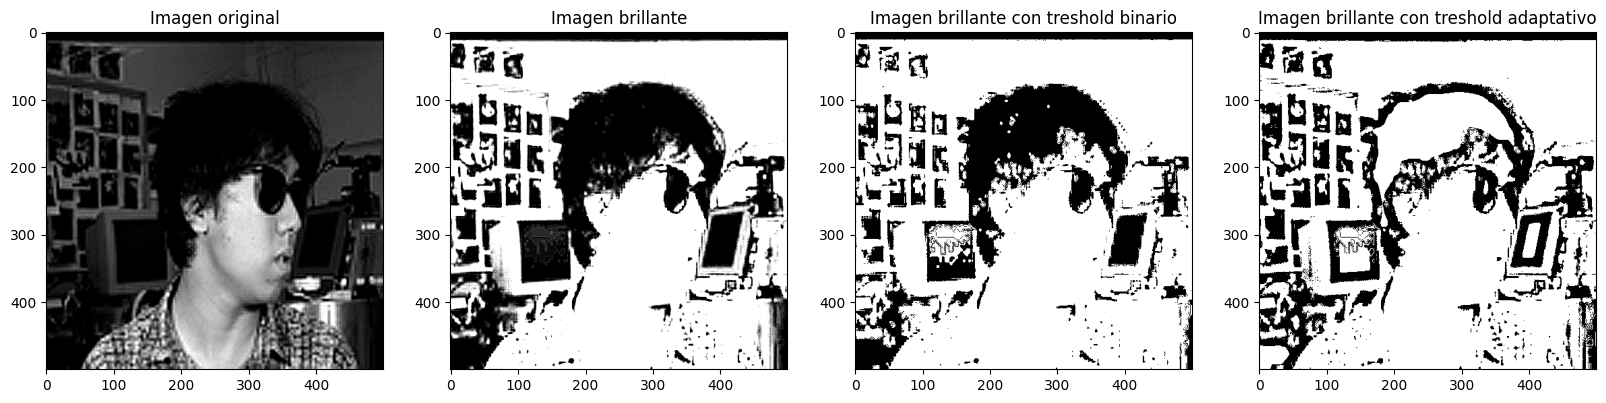

In [39]:
#Se grafican los resultados brillantes
fig, ax = plt.subplots(1, 4, figsize=(20, 6))
plt.title('Imagen brillante')
ax[0].imshow(sharpened_img_cubic, cmap='gray')
ax[0].set_title('Imagen original')
ax[1].imshow(img_brillante, cmap='gray')
ax[1].set_title('Imagen brillante')
ax[2].imshow(img_brillante_treshold, cmap='gray')
ax[2].set_title('Imagen brillante con treshold binario')
ax[3].imshow(img_brillante_treshold_adaptative, cmap='gray')
ax[3].set_title('Imagen brillante con treshold adaptativo')
plt.show()

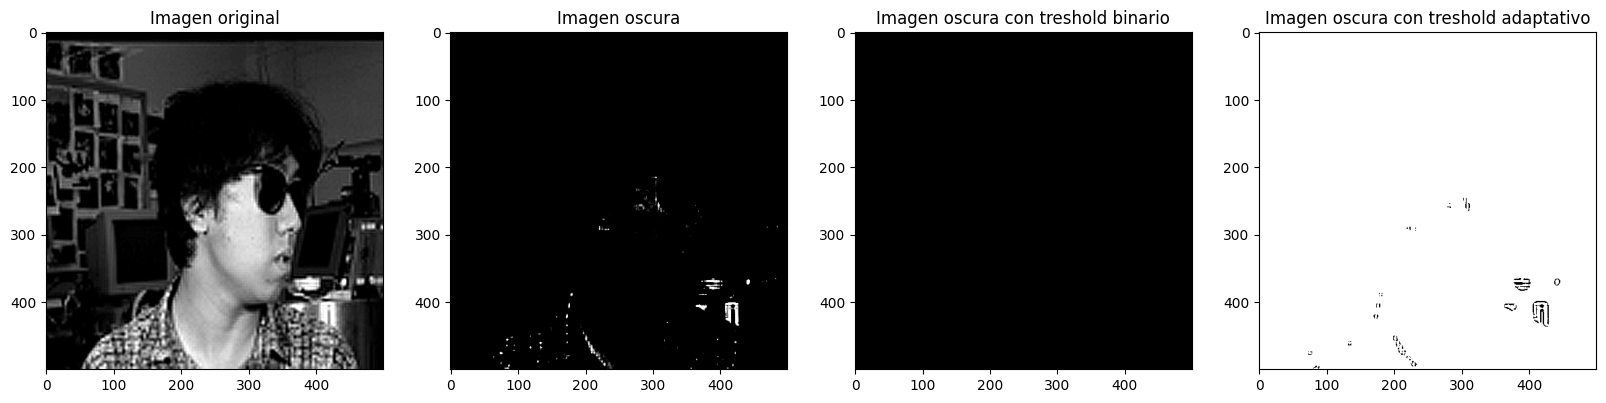

In [40]:
#Se grafican los resultados oscuros
fig, ax = plt.subplots(1, 4, figsize=(20, 6))
plt.title('Imagen oscura')
ax[0].imshow(sharpened_img_cubic, cmap='gray')
ax[0].set_title('Imagen original')
ax[1].imshow(img_oscura, cmap='gray')
ax[1].set_title('Imagen oscura')
ax[2].imshow(img_oscura_treshold, cmap='gray')
ax[2].set_title('Imagen oscura con treshold binario')
ax[3].imshow(img_oscura_treshold_adaptative, cmap='gray')
ax[3].set_title('Imagen oscura con treshold adaptativo')
plt.show()

### Concluimos que la que mejor resalta la caracteristica necesaria es tanto la oscura con treshold binario como la clara con treshold binario, por lo tanto elegimos el metodo claro con treshold binario, exactamente una suma de 50 a la imagen original y un treshold apartir de 160 a 255. Realizamos una funcion donde se aplique lo anterior mencionado a todas las imagenes para observar como se comporta el preprocesamiento   

In [63]:
#Funcion para procesar cada imagen
def procesar_imagen(ruta):
  img = cv2.imread(ruta, cv2.IMREAD_GRAYSCALE)
  high_res_img_cubic = cv2.resize(img, (500, 500), interpolation=cv2.INTER_CUBIC)
  kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
  sharpened_img_cubic = cv2.filter2D(high_res_img_cubic, -1, kernel)
  matriz = np.ones(sharpened_img_cubic.shape, dtype=np.uint8)*150
  img_brillante = cv2.add(sharpened_img_cubic, matriz)
  img_brillante_treshold = cv2.threshold(img_brillante, 170, 255, cv2.THRESH_BINARY)[1]
  return img_brillante_treshold

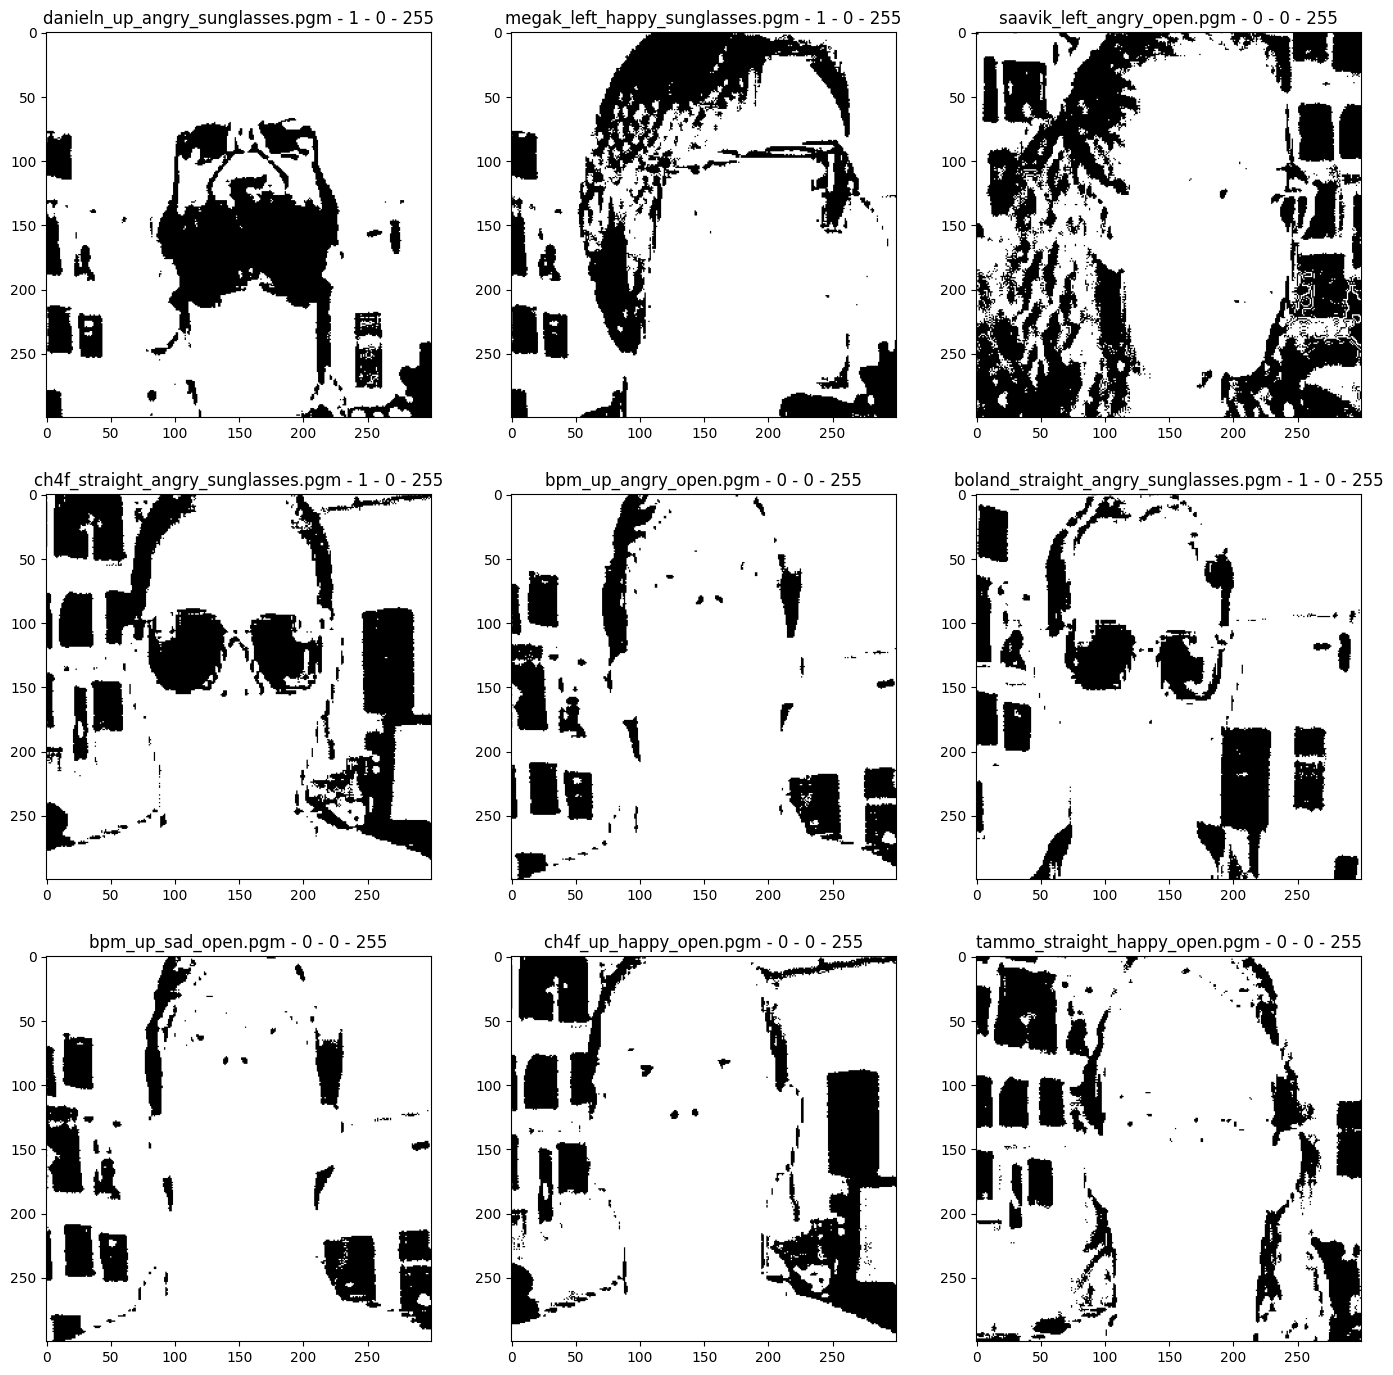

In [45]:
#Aplicar la funcion a una muestra aleatoria de nueve imagenes
fig, ax = plt.subplots(3,3 ,figsize=(17,17))
for i in ax.flatten():
  nombre, etiqueta = df.sample().values[0]
  img = procesar_imagen(f'imagenes/{nombre}')
  i.imshow(img, cmap='gray')
  i.title.set_text(f'{nombre} - {etiqueta} - {img.min()} - {img.max()}')

### Observamos que en general se aplica bien el procesamiento y se segmenta las gafas de sol cuando estas existen en la imagen

In [39]:
#Creamos un nuevo directorio para guardar las imagenes procesadas
#os.makedirs('imagenes_procesadas', exist_ok=True)

In [6]:
#Extreamos los nombres de las imagenes
#nombres_archivos = os.listdir('imagenes')

In [64]:
#Aplicamos la funcion a todas las imagenes del dataset y guardamos los resultados
#for i in nombres_archivos:
  #img = procesar_imagen(f'imagenes/{i}')
  #cv2.imwrite(f'imagenes_procesadas/{i}', img)

<center>

# 2.  Creacion de modelo

</center>

## 2.1 Carga y ajustes de datos

In [65]:
#Creamos una funcion auxiliar que se encargara de cargar las imagenes
def cargar_imagen(ruta):
    imagen = Image.open(f'imagenes_procesadas/{ruta}')
    imagen = imagen.resize((300,300))
    imagen = np.array(imagen)
    imagen = imagen/255
    return imagen

In [66]:
#Cargamos las imagenes procesadas al dataframe para luego ser usadas en el modelo
df['imagen_valores'] = df['Image'].apply(cargar_imagen)

In [70]:
#Partimos el conjunto de datos en entrenamiento y validacion
X_train, X_test, Y_train, Y_test = train_test_split(df['imagen_valores'], df['Sunglasses'], test_size=0.2, random_state=48)

In [73]:
#Convertimos los datos a arrays admitidos por el modelo
X_train = np.array(X_train.tolist())
X_test = np.array(X_test.tolist())
Y_train = np.array(Y_train.tolist())
Y_test = np.array(Y_test.tolist())

## 2.2 Definicion del modelo

### Para la definicion del modelo usamos una red neuronal convolucional con 2 capas de convolucion y 2 de agrupamiento. Ademas agregamos un dropout del 50% para evitar la dependencia excesiva de ciertas neuronas, lo que reduce el overfitting. Luego se transforma la salida de las capas convolucionales en un vector plano admitido por las capas densas y finalizamos con una capa densa de salida con activacion sigmoide para clasificacion binaria  

In [79]:
#Definimos el modelo de red neuronal convolucional
model = Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 1)),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(100, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [80]:
#Ajustamos el modelo a los datos de entrenamiento y comprovamos su efiacia con los datos de validacion
history = model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_test, Y_test))


Epoch 1/10
18/18 [==============================] - 35s 2s/step - loss: 4.1775 - accuracy: 0.5383 - val_loss: 0.6908 - val_accuracy: 0.6667
Epoch 2/10
18/18 [==============================] - 33s 2s/step - loss: 0.6914 - accuracy: 0.5811 - val_loss: 0.6899 - val_accuracy: 0.6508
Epoch 3/10
18/18 [==============================] - 32s 2s/step - loss: 0.6874 - accuracy: 0.6043 - val_loss: 0.6826 - val_accuracy: 0.6825
Epoch 4/10
18/18 [==============================] - 32s 2s/step - loss: 0.6439 - accuracy: 0.7077 - val_loss: 0.5819 - val_accuracy: 0.7619
Epoch 5/10
18/18 [==============================] - 32s 2s/step - loss: 0.4412 - accuracy: 0.8253 - val_loss: 0.5687 - val_accuracy: 0.6825
Epoch 6/10
18/18 [==============================] - 33s 2s/step - loss: 0.2886 - accuracy: 0.8806 - val_loss: 0.3072 - val_accuracy: 0.8571
Epoch 7/10
18/18 [==============================] - 33s 2s/step - loss: 0.1818 - accuracy: 0.9340 - val_loss: 0.2510 - val_accuracy: 0.9365
Epoch 8/10
18/18 [==

## 2.3 visualizacion de resultados

In [130]:
#Hacemos una prediccion con los datos de validacion
Y_pred = model.predict(X_test)
Y_pred = np.round(Y_pred)

2/2 [==============================] - 1s 397ms/step


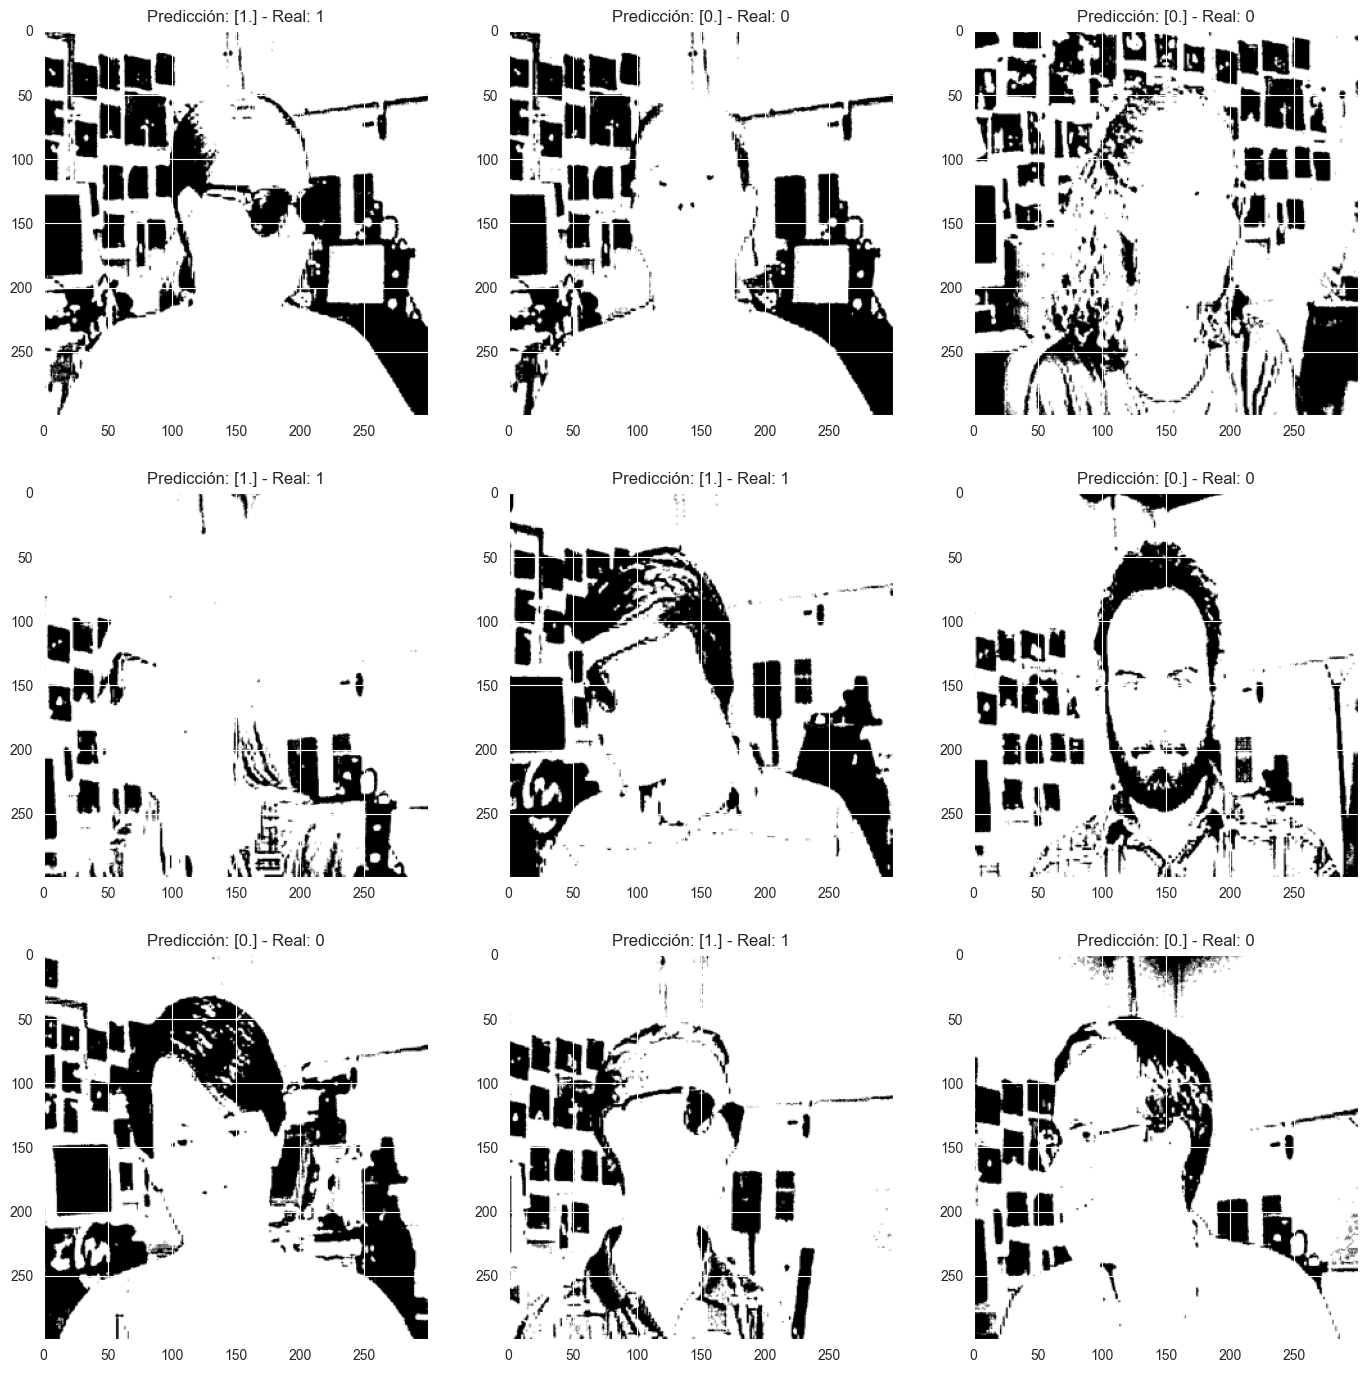

In [133]:
#Graficamos las imagenes con su prediccion y su valor real
fig, ax = plt.subplots(3, 3, figsize=(17, 17))
for ax in ax.flatten():
  i = np.random.randint(0, len(X_test))
  ax.imshow(X_test[i], cmap='gray')
  ax.title.set_text(f'Predicción: {Y_pred[i]} - Real: {Y_test[i]}')

### Para estas nueve muestras aleatorias del conjunto de testeo observamos una prediccion perfecta del modelo

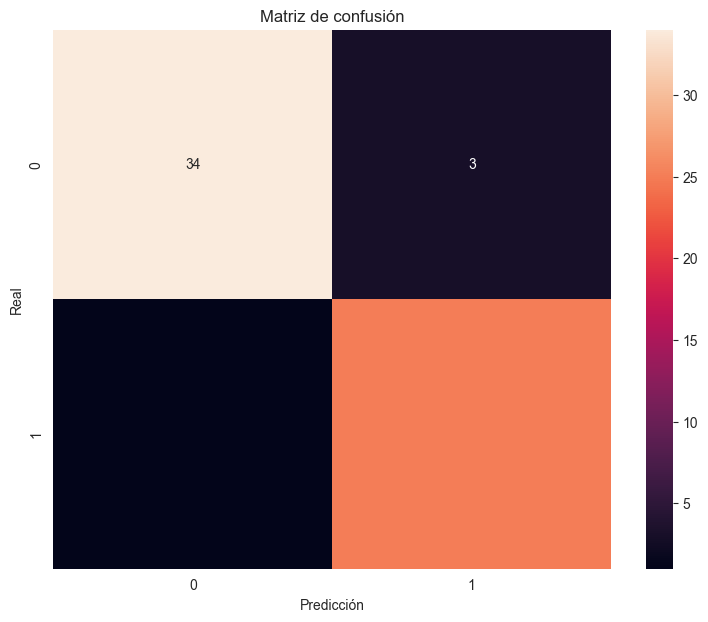

In [142]:
#Graficamos la matriz de confusión
plt.figure(figsize=(9, 7))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, fmt='d')
plt.title('Matriz de confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

In [145]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94        37
           1       0.89      0.96      0.93        26

    accuracy                           0.94        63
   macro avg       0.93      0.94      0.94        63
weighted avg       0.94      0.94      0.94        63



In [82]:
#Extraemos los valores de perdida y precision de los datos de entrenamiento y validacion
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

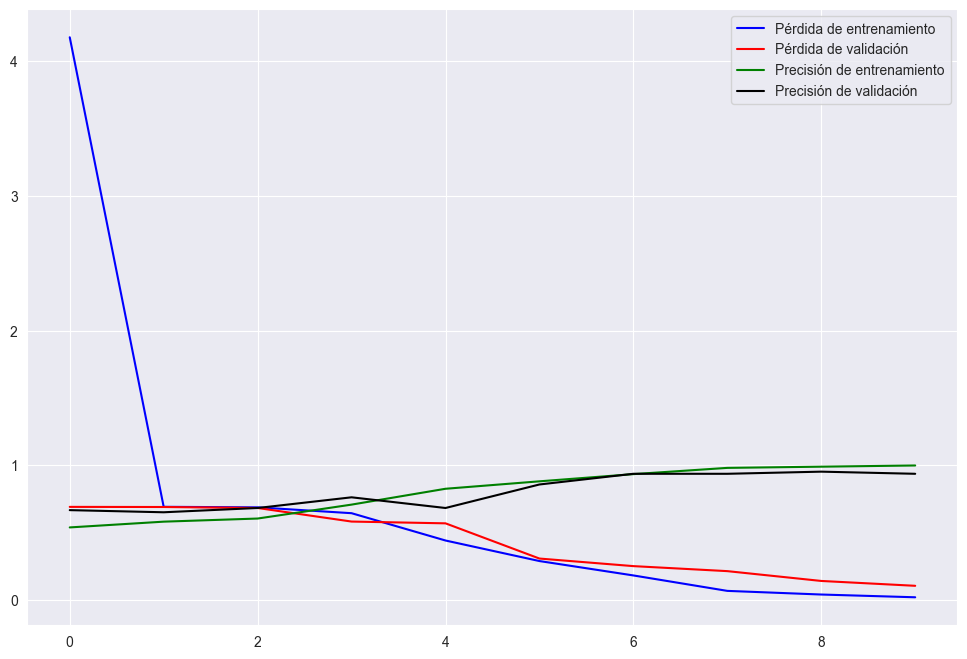

In [110]:
#Graficamos los resultados
plt.figure(figsize=(12, 8))
sns.lineplot(x=range(len(train_loss)), y=train_loss, color='blue', label='Pérdida de entrenamiento')
sns.lineplot(x=range(len(val_loss)), y=val_loss, color='red', label='Pérdida de validación')
sns.lineplot(x=range(len(train_acc)), y=train_acc, color='green', label='Precisión de entrenamiento')
sns.lineplot(x=range(len(val_acc)), y=val_acc, color='black', label='Precisión de validación')
plt.show()

### Concluimos que el aprendizaje del modelo apartir del dataset suministrado fue exitoso, consiguiendo un accuracy elevado y una buena generalizacion para datos no vistos con anterioridad, lo que traduce en un porcentaje de overfitting bajo  